# Melanomsegmentierung auf dem ISIC 2018 Datensatz

Während es bei der Objektdetektion primär darum geht, Objekte auf einem Bild zu finden und zu unterscheiden, geht es bei der Segmentierung darum, jedem Pixel eines Bildes eine Klasse zuzuweisen und das Bild so in verschiedene Bereiche zu segmentieren. Das Ergebnis von Objektdetektion sind überlicherweise Bounding Boxes, während bei der Segmentierung die genauen Umrisse von Objekten ausgegeben werden.

Der Code ist adaptiert von [train_shapes](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb).

## Datensatz

Die [ISIC 2018](https://challenge2018.isic-archive.com/task1/) Datensatz umfasst 2596 Hautbilder mit genau einer prmären Lesion (Hautveränderung) und 2596 zugehörige Segmentierungsmasken.

<img src="https://challenge2018.isic-archive.com/wp-content/uploads/2018/04/task1.png" />
Quelle: https://challenge2018.isic-archive.com/task1/

Für unser Training wurde ein Subset von 556 Bilder der größe 1024x768 ausgewählt, um das Einlesen des Datensatzes zu beschleunigen. Diese werden in einen Trainingsdatensatz von 400 und einen Validierungsdatensatz von 156 aufgeteilt.

Das Ziel unseres Modells besteht in der automatischen Erstellung der Segmentierungmasken für Hautbilder.

# 1. Imports und Setup

Wie bei der Klassifikation werden hier benötigte Bibliotheken importiert, Funktionen definiert und Konstanten festgelegt.

In [1]:
import os
import logging
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import csv
from PIL import Image
from scipy.interpolate import make_interp_spline, BSpline

# Root directory of the project
MRCNN_DIR = os.path.abspath("/mrcnn/")
ROOT_DIR = os.path.abspath("/workspace")
PRETRAINED_MODEL_DIR = os.path.abspath("/models")
DATA_DIR = os.path.abspath("/data")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(PRETRAINED_MODEL_DIR, "mask_rcnn_coco.h5")


import tensorflow as tf

# Tell TF to not use all GPU RAM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

from tensorflow.keras.callbacks import Callback

import asyncio
import concurrent

# Import Mask RCNN
sys.path.append(MRCNN_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def smooth(values, num_points = 100):
    xnew = np.linspace(0,len(values)-1,num_points) #100 represents number of points to make between T.min and T.max
    spl = make_interp_spline(list(range(len(values))), values, k=3) #BSpline object
    values_smooth = spl(xnew)
    
    return xnew, values_smooth

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.rpn_class_loss = []
        self.rpn_bbox_loss = []
        self.mrcnn_class_loss = []
        self.mrcnn_bbox_loss = []
        self.mrcnn_mask_loss = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.rpn_class_loss.append(logs.get('rpn_class_loss'))
        self.rpn_bbox_loss.append(logs.get('rpn_bbox_loss'))
        self.mrcnn_class_loss.append(logs.get('mrcnn_class_loss'))
        self.mrcnn_bbox_loss.append(logs.get('mrcnn_bbox_loss'))
        self.mrcnn_mask_loss.append(logs.get('mrcnn_mask_loss'))

print("Setup done")
print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Pre-trained model directory:", PRETRAINED_MODEL_DIR)
print("M-RCNN directory:", MRCNN_DIR)
print("Datasets directory:", DATA_DIR)

1 Physical GPUs, 1 Logical GPUs
Setup done
Directories:
Root directory: /workspace
Model directory: /workspace/logs
Pre-trained model directory: /models
M-RCNN directory: /mrcnn
Datasets directory: /data


## 1.1 Ordnerstruktur

Im folgenden können die oben aufgelisteten Verzeichnisse inspiziert werden, um sich mit der Ordnerstruktur vertraut zu machen.

Fehlermeldungen der Art `"write error: broken pipe"` können ignoriert werden.

In [ ]:
!ls -l /workspace
!ls -l /data/ISIC_2018
!ls -l /workspace/logs
!ls -l /models
!ls -l /mrcnn
!ls -l /data/ISIC_2018/train | head -n10

# 2. Konfiguration

An dieser Stelle wird die Konfiguration des Modells festgelegt. Zur Optimierung werden wir später an diesen Punkt zurück kehren.

Die wichtigsten Stellschrauben sind:

- `IMAGES_PER_GPU`: dies ist in unserem Fall die Batchgröße, da `GPU_COUNT` immer 1 bleibt. Diese Zahl kann erhöht werden, da wir aber nur 40% des GPU-Speichers zur Verfügung haben, kann dies zur Trainingsabstürzen führen.
- `RPN_ANCHOR_SCALES`: Ein "Anchor" ist bei dem MRCNN-Modell eine vom ersten Netzwerk (RPN) vorgeschlagene Region, hier kann festgelegt werden, welche Größenordnungen dieser Anchor haben dürfen (bezogen auf das skalierte Bild, nicht das Originalbild). Da die Lesions teilweise relativ klein, an anderen Stellen aber auch das komplette Bild einnehmen, kann man hier eher am unteren Ende des Spektrums noch etwas entfernen als am oberen.
- `TRAIN_ROIS_PER_IMAGE`: Wie viele ROIs sollen pro Bild gesucht werden? Für kurze Trainingsläufe ist es besser hier eine kleine Zahl zu wählen, da ansonsten zu viele Objekte auf den Bildern gefunden werden. Für längere Trainingsläufe sollte die Zahl etwa dem Dreifachen der erwarteten Objekte entsprechen, da der Klassifikator dann die false positives noch herausfiltern kann. Wählt man die Zahl zu klein, kann es sein dass das Modell nicht konvergiert.
- `LEARNING_RATE`: die wohl wichtigste Stellschraube während des Trainingsprozesses. Ist diese Zahl zu klein, dann wird nur langsam gelernt, ist diese Zahl zu groß dann besteht die Gefahr dass das Netzwerk nicht konvergiert, der Netzwerkfehler also über die Zeit konstant bleibt oder fluktuiert. Sinnvolle Startwerte sind z.B. 0.0001 oder 0.001
- `LEARNING_MOMENTUM`: beeinflusst den Einflusst des letzten Gewichtsupdates auf das aktuelle Gewichtsupdate. Kann z.B. auf 0.5 reduziert werden oder deaktiviert werden.
- `WEIGHT_DECAY`: beeinflusst das Schrumpfen von Gewichten die nicht verändert wurden. Kann deaktiviert werden, sollte nicht zu viel erhöht werden.
- `DETECTION_MIN_CONFIDENCE`: gibt an ab welchen Konfidenzlevel das Modell ein gefundenes Objekt ausgeben soll. Wenn zu wenige Objekte angezeigt kann diese Zahl reduziert werden. Dies kann jedoch dazu führen, dass öfter falsche Objekte angezeigt werden.
- `STEPS_PER_EPOCH`: Aus wie vielen Schritten (also Mini-Batches) eine Epoche besteht. Da wir 400 Bilder und eine Batchgröße von 8 haben, brauchen wir 50 Schritte um einmal über alle Bilder zu iterieren.
- `VALIDATION_STEPS`: Nach jeder Epoch wird der Validierungsfehler berechnet, wir haben 156 Validierungsbilder, also bräuchten wir 20 Schritte um über diese zu iterieren. Um die Trainingszeit zu reduzieren, wird auch nur 5 genommen

Aufgaben:

- Wählen Sie eine geeignete Lernrate (`LEARNING_RATE`)

In [2]:
class ISIC2018Config(Config):
    """Configuration for training on the bone age dataset.
    Derives from the base Config class and overrides values specific
    to the bone age dataset.
    """
    # Give the configuration a recognizable name
    NAME = "isic"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + lesion

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 5
    
    LEARNING_RATE = ___LERNRATE_EINTRAGEN___
    
    LEARNING_MOMENTUM = 0.9
    
    WEIGHT_DECAY = 0.0001
    
    DETECTION_MIN_CONFIDENCE = 0.75
    
    MINI_MASK_SHAPE=(128,128)

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 50

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ISIC2018Config()
config.display()

print("Configuration done")


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

# 3. Datensatz

Hier wird die Datensatz-Klasse definiert, in der u.a. die folgenden Methoden vorhanden sind:

* load_isic(): Initialisiert den Datensatz, indem die Bilder aus dem Trainingsverzeichnis geladen werden (bzw. in diesem Fall werden nur die Dateinamen geladen)
* load_image(): Lädt ein einzelnes Bild aus dem Datensatz – diese Funktion wird von der Klasse [`utils.Dataset`](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py#L239) geerbt, die aufgrund des in `load_isic()` für das Bild übergebenen Pfades das Bild vom Dateisystem lädt.
* load_mask(): Lädt die zugehörige Segmentierungsmaske

In [3]:
class ISIC2018Dataset(utils.Dataset):
    """Generates the bone age dataset.
    """

    def load_isic(self, image_dir, mask_dir, image_range):
        """Load the requested subset of the ISIC dataset.
        """
        # Add classes
        self.add_class("isic", 1, "lesion")

        directory = os.fsencode(image_dir)

        i = 0
        for file in os.listdir(directory):
            i+=1
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                if not i in image_range:
                    continue
                    
                image_id = filename.split(".")[0].split("_")[1]
                image_path = os.path.join(image_dir, filename)
                #height, width, _ = cv2.imread(image_path).shape
                # print(os.path.join(directory, filename))
                self.add_image(
                    "isic", image_id=image_id,
                    path=image_path,
                    mask_path=os.path.join(mask_dir, "ISIC_" + image_id + "_segmentation.png"),
                    width=1024,
                    height=768)
                

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "isic":
            return "https://challenge2018.isic-archive.com/task1/"
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for instances in the given image.
        """
        instance_masks = []
        class_ids = []
        image_info = self.image_info[image_id]
        mask_path = image_info["mask_path"]
        
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        img = Image.open(mask_path)
        mask = np.array(img.getdata(), np.uint8).reshape(image_info["height"], image_info["width"])
            #.reshape(image_info["height"], image_info["width"])/255
        instance_masks.append(mask)
        class_ids.append(1)

        # Pack instance masks into an array
        masks = np.reshape(np.stack(instance_masks, axis=2).astype(np.bool), (1, image_info["height"], image_info["width"], len(class_ids)))[0]
        class_ids = np.array(class_ids, dtype=np.int32)
        return masks, class_ids

print("Dataset created")

Dataset created


Hier werden nun Trainings- und Validierungsdatensatz initialisiert. Die Bilder liegen gesammelt im Unterverzeichnis `train`, die Segmentierungsmasken im Unterverzeichnis `ISIC2018_Task1_Training_GroundTruth`. Über die im Anschluss angegebene `range()` wird bestimmt welche Bilder zum Training und zur Validierung genommen werden.

Fehlermeldungen der Art `"write error: broken pipe"` können ignoriert werden.

Aufgaben:

- Geben Sie die korrekten Pfade für Trainings- und Validierungsdatensatz an

In [4]:
!ls -l /data/ISIC_2018
!ls /data/ISIC_2018/train | wc -l
!ls -l /data/ISIC_2018/train | head -n10
!ls -l /data/ISIC_2018/ISIC2018_Task1_Training_GroundTruth | head -n10

total 172
drwxrwxr-x 2 517 999 147456 Aug 28  2019 ISIC2018_Task1_Training_GroundTruth
drwxrwxr-x 2 517 999  20480 Aug 28  2019 train
556
total 88076
-rw-rw-r-- 1 517 999 134020 Aug 28  2019 ISIC_0000236.jpg
-rw-rw-r-- 1 517 999 128110 Aug 28  2019 ISIC_0000239.jpg
-rw-rw-r-- 1 517 999 117368 Aug 28  2019 ISIC_0000240.jpg
-rw-rw-r-- 1 517 999 152121 Aug 28  2019 ISIC_0000242.jpg
-rw-rw-r-- 1 517 999 151532 Aug 28  2019 ISIC_0000244.jpg
-rw-rw-r-- 1 517 999 122291 Aug 28  2019 ISIC_0000245.jpg
-rw-rw-r-- 1 517 999 143769 Aug 28  2019 ISIC_0000246.jpg
-rw-rw-r-- 1 517 999 125959 Aug 28  2019 ISIC_0000247.jpg
-rw-rw-r-- 1 517 999 132954 Aug 28  2019 ISIC_0000249.jpg
ls: write error: Broken pipe
total 52032
-rw-rw-r-- 1 517 999    441 Aug 28  2019 ATTRIBUTION.txt
-rw-rw-r-- 1 517 999   4590 Aug 28  2019 ISIC_0000000_segmentation.png
-rw-rw-r-- 1 517 999   2659 Aug 28  2019 ISIC_0000001_segmentation.png
-rw-rw-r-- 1 517 999   4962 Aug 28  2019 ISIC_0000003_segmentation.png
-rw-rw-r-- 1 517 

In [5]:
# Training dataset
dataset_train = ISIC2018Dataset()
dataset_train.load_isic("load_isic",
                        "___PFAD_EINTRAGEN___", range(1,400))
dataset_train.prepare()

# Validation dataset
dataset_val = ISIC2018Dataset()
# training and evaluation data are taken from the same directory
dataset_val.load_isic("___PFAD_EINTRAGEN___", 
                        "___PFAD_EINTRAGEN___", range(401,556))
dataset_val.prepare()

print("Dataset prepared")

Dataset prepared


## 3.1 Beispielbilder

Hier werden nun zufällig ein paar Bilder mit den zugehörigen Masken geladen und angezeigt. Diese Zelle kann mehrfach ausgeführt werden. Falls die Zelle anfängt zu scrollen kann dies mit `Shift + o` deaktiviert werden.

Image shape: (768, 1024, 3)
Mask shape: (768, 1024, 1)


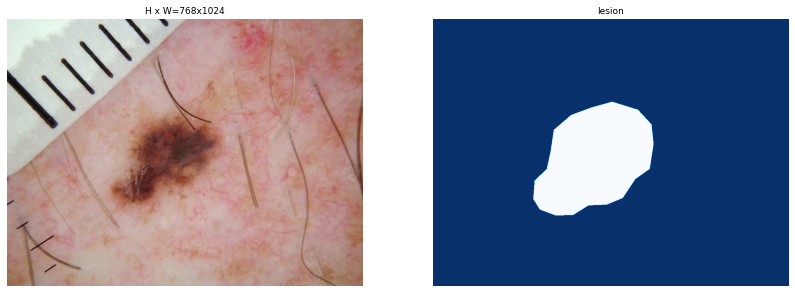

Image shape: (768, 1024, 3)
Mask shape: (768, 1024, 1)


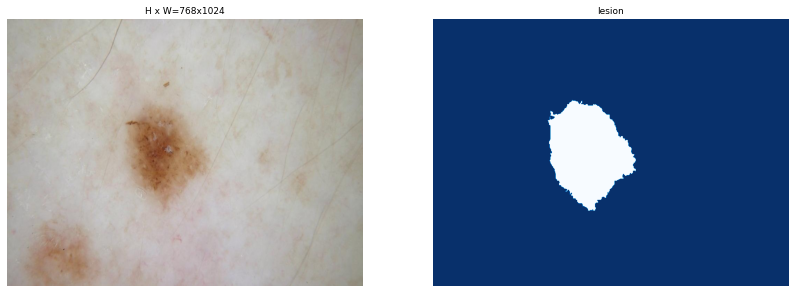

Image shape: (768, 1024, 3)
Mask shape: (768, 1024, 1)


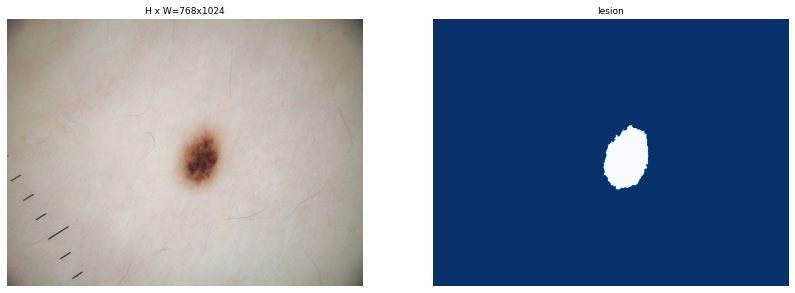

Image shape: (768, 1024, 3)
Mask shape: (768, 1024, 1)


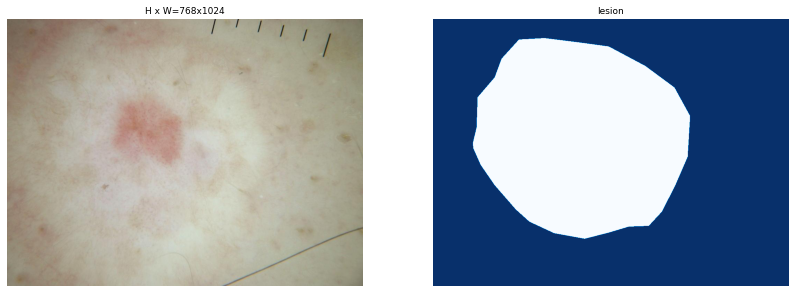

In [6]:
NUM_IMAGES = 4

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, NUM_IMAGES, replace=False)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print("Image shape: " + str(image.shape))
    print("Mask shape: " + str(mask.shape))
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

# 4. Modellerstellung

Hier wird das Modell erstellt. Initial werden drei Parameter übergeben:

- der Modell-Modus (`training` oder `inference`)
- die oben definierte Konfiguration
- das Verzeichnis indem das Modell gespeichert / geladen werden soll

Anschließend werden die Gewichte des Modells initialisiert, mögliche Werte für `init_with` sind

- `imagenet`: initialisiert das Modell mit Gewichten die auf dem Imagenet Datensatz trainiert wurden
- `coco`: initialisiert das Modell mit Gewichten die auf dem MS COCO Datensatz trainiert wurden
- `last`: versucht das zuletzt trainierte Modell zu laden. Nur sinnvoll wenn ein solches Modell im angegebenen Ordner existiert
- `manual`: versucht das Modell aus der in `MANUAL_MODEL_PATH` angegebenen Datei zu laden

Aufgaben:

- Tragen Sie den passenden `mode` Parameter für den Modell-Modus ein
- Wählen Sie den passenden Wert für die `init_with` Variable um das Modell mit auf dem MS COCO Datensatz trainierten Gewichten zu initialisieren

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="___MODELL-MODUS_EINTRAGEN___", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "___WERT_EINTRAGEN___"  # imagenet, coco, manual, or last
MANUAL_MODEL_PATH = "/models/mask_rcnn_bone_age_0100.h5"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "manual":
    model.load_weights(MANUAL_MODEL_PATH, by_name=True)
    
print("Model created")

Model created


## 4.1 Training (Schritt 1)

Nun findet das Training des Modells statt.

Der Funktion [`model.train`](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py#L2276) werden hierzu

- die Trainings- und Validierungsdatensätze,
- die Lernrate (die oben in der Konfiguration festgelegt wurde),
- die Anzahl Epochen (hier auf 2 gesetzt da es sonst zu lange dauert) und
- die zu trainierenden Schichten

übergeben.

Das Training geschieht in zwei Schritten:

1. nur die obersten, neu hinzugefügten Schichten. Dazu werden die Gewichte in den anderen Schichten eingefroren und beim Training nicht verändert. Um das zu erreichen, wird dem `layers` Parameter der Wert `heads` übergeben.

2. anschließendes Fine-tuning aller Schichten mit `layers="all"`

In beiden Schritten wird für 2 Epochen trainiert, was zusammen weniger als 10 Minuten dauern sollte.

Aufgaben:

- Wählen Sie den passenden Wert für die `layers`-Variable

In [10]:
history = LossHistory()

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=2,
            custom_callbacks=[history],
            layers='heads')
print("Finished training")


Starting at epoch 0. LR=0.001

Checkpoint Path: /workspace/logs/isic20200615T1021/mask_rcnn_isic_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

Die Ausgabe des Trainingsscripts enthält folgende Informationen:

- `8/50`: Das aktuelle Minibatch. Wie oben beschrieben ergibt sich die Zahl 50 aus der Anzahl Trainingsbilder durch die Batch-Größe: `400 / 8 = 50`
- `ETA: 1:55`: Erwartete Restzeit
- `413s 180ms/step`: Gesamtdauer für die Trainingsepoche sowie durchschnittliche Dauer eines Minibatches
- `loss: 1.3854`: Wert der zu minimierenden Verlustfunktion auf dem letzten Minibatch
- `rpn_class_loss` und `rpn_bbox_loss`: Werte der Verlustfunktion für das Netzwerk welches die ROIs vorschlägt, einerseits für die Objektklassen und andererseits für die Bounding Boxes, jeweils für das letzte Trainings-Minibatch
- `mrcnn_class_loss`, `mrcnn_bbox_loss` und `mrcnn_mask_loss` sind die entsprechenden Werte der Verlustfunktion für die Klassifikation, die Bounding Boxen und die Segmentierungsmasken (M-RCNN arbeitet intern immer mit diesen Masken), jeweils für das letzte Trainings-Minibatch
- `val_*:`: Die entsprechenden Werte auf dem gesamten Validierungsdatensatz. Wird nur einmal pro Epoche generiert

Die `*_class` Fehler sind hier erwartungsgemäß sehr gering, da es nur eine Klasse (bzw. zwei wenn man die Klasse "Hintergrund" dazu zählt) gibt.

###  4.1.1 Visualisierung (Schritt 1)

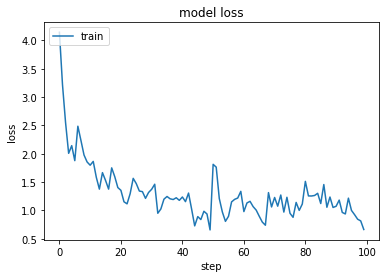

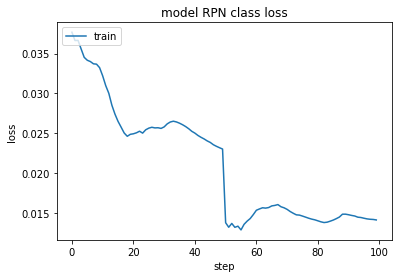

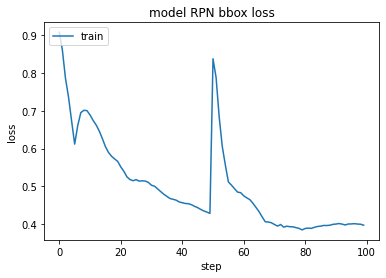

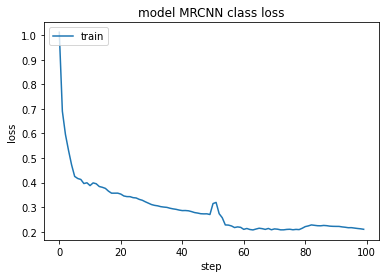

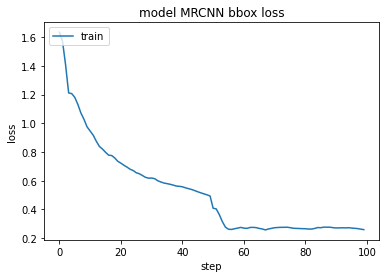

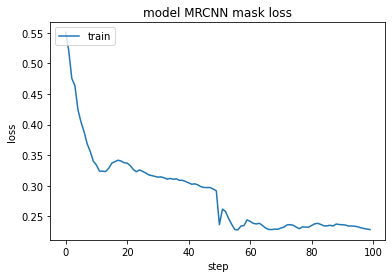

In [11]:
# summarize history for loss
plt.plot(*smooth(history.loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.rpn_class_loss))
plt.title('model RPN class loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.rpn_bbox_loss))
plt.title('model RPN bbox loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.mrcnn_class_loss))
plt.title('model MRCNN class loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.mrcnn_bbox_loss))
plt.title('model MRCNN bbox loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.mrcnn_mask_loss))
plt.title('model MRCNN mask loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

### 4.1.2 Detection (Schritt 1)

Nach dem Training schauen wir uns jetzt an wie gut unser Modell funktioniert. Dazu wird die Batch-Größe auf 1 gesetzt und ein Modell mit dem Modus `inference` erstellt und anschließend die Gewichte vom Training geladen.

Aufgaben:

- Setzen Sie den korrekten Modell-Modus

In [12]:
class InferenceConfig(ISIC2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="___MODELL-MODUS_EINTRAGEN___", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
#model_path = os.path.join(PRETRAINED_MODEL_DIR, "mask_rcnn_isic_0050.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /workspace/logs/isic20200615T1021/mask_rcnn_isic_0002.h5
Re-starting from epoch 2


Hier wird nun ein zufälliges Bild aus dem Datensatz genommen und zunächst das Original mit der zugehörigen Segmentierungsmakse und dann das Bild mit der vom Modell vorausgesagten Maske und zugehörigem Konfidenzwert angezeigt.

Diese Zelle kann mehrfach ausgeführt werden.

original_image           shape: (128, 128, 3)         min:    0.00000  max:  245.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   17.00000  max:  101.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


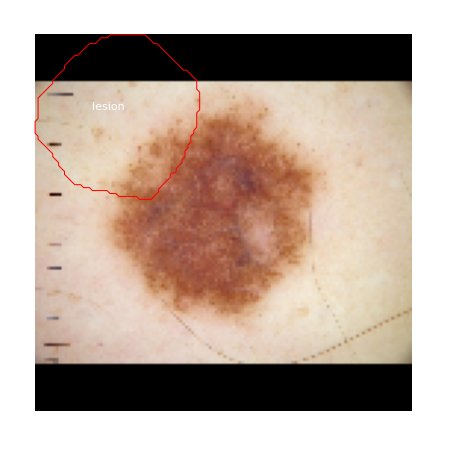

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  245.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  121.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4080, 4)          min:   -0.71267  max:    1.46071  float32


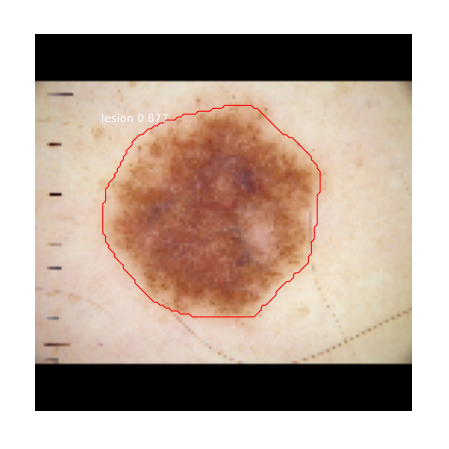

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8), show_bbox=False, show_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False, show_mask=False)

## 4.2 Training (Schritt 2)

Nun wird das gesamte Netzwerk mit einer reduzierten Lernrate für zwei weitere Epochen trainiert.

Aufgaben:

- Wählen Sie den passenden Wert für die `layers`-Variable

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, manual, or last
MANUAL_MODEL_PATH = "/models/mask_rcnn_bone_age_0100.h5"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
elif init_with == "manual":
    model.load_weights(MANUAL_MODEL_PATH, by_name=True)

Re-starting from epoch 2


In [17]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=4,
            custom_callbacks=[history],
            layers="___WERT_EINTRAGEN___")

print("Training finished")


Starting at epoch 2. LR=0.0001

Checkpoint Path: /workspace/logs/isic20200615T1021/mask_rcnn_isic_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

Epoch 3/4
50/50 [==============================] - 623s 12s/step - loss: 0.7831 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.1720 - val_loss: 0.8478 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 0.3609 - val_mrcnn_class_loss: 0.1486 - val_mrcnn_bbox_loss: 0.1627 - val_mrcnn_mask_loss: 0.1664
Epoch 4/4
50/50 [==============================] - 153s 3s/step - loss: 0.7625 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1851 - val_loss: 0.8804 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.2111 - val_mrcnn_class_loss: 0.2183 - val_mrcnn_bbox_loss: 0.1750 - val_mrcnn_mask_loss: 0.2673
Training finished


### 4.2.1 Visualisierung (Schritt 2)

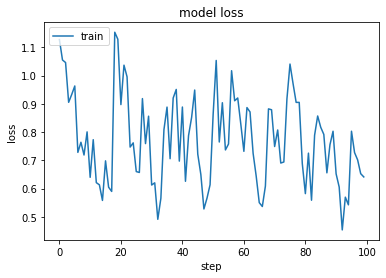

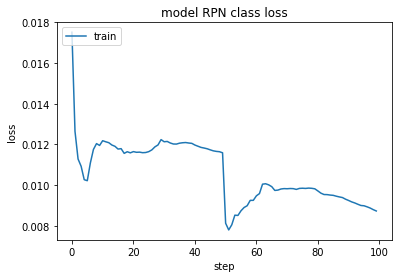

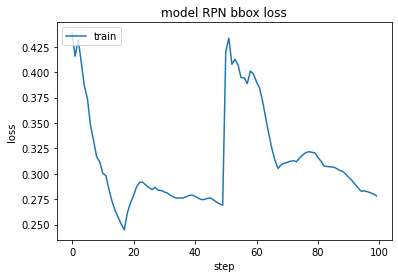

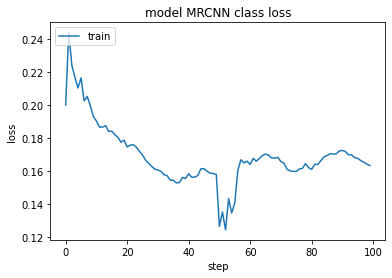

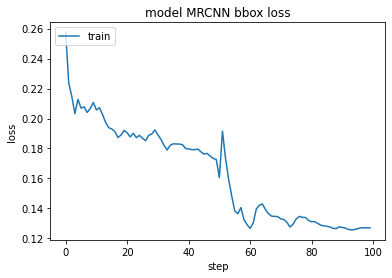

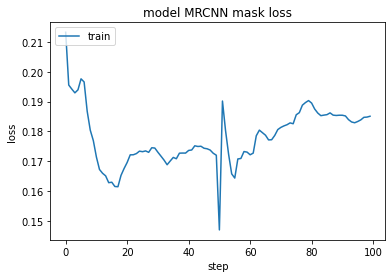

In [18]:
# summarize history for loss
plt.plot(*smooth(history.loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.rpn_class_loss))
plt.title('model RPN class loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.rpn_bbox_loss))
plt.title('model RPN bbox loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.mrcnn_class_loss))
plt.title('model MRCNN class loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.mrcnn_bbox_loss))
plt.title('model MRCNN bbox loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(*smooth(history.mrcnn_mask_loss))
plt.title('model MRCNN mask loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train'], loc='upper left')
plt.show()

### 4.2.2 Detection (Schritt 2)

Nach dem Training schauen wir uns jetzt an wie gut unser Modell funktioniert. Dazu wird die Batch-Größe auf 1 gesetzt und ein Modell mit dem Modus `inference` erstellt und anschließend die Gewichte vom Training geladen.


In [19]:
class InferenceConfig(ISIC2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
#model_path = os.path.join(PRETRAINED_MODEL_DIR, "mask_rcnn_isic_0050.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /workspace/logs/isic20200615T1021/mask_rcnn_isic_0004.h5
Re-starting from epoch 4


Hier wird nun ein zufälliges Bild aus dem Datensatz genommen und zunächst das Original mit der zugehörigen Segmentierungsmakse und dann das Bild mit der vom Modell vorausgesagten Maske und zugehörigem Konfidenzwert angezeigt.

Diese Zelle kann mehrfach ausgeführt werden.

original_image           shape: (128, 128, 3)         min:    0.00000  max:  214.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   22.00000  max:  100.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


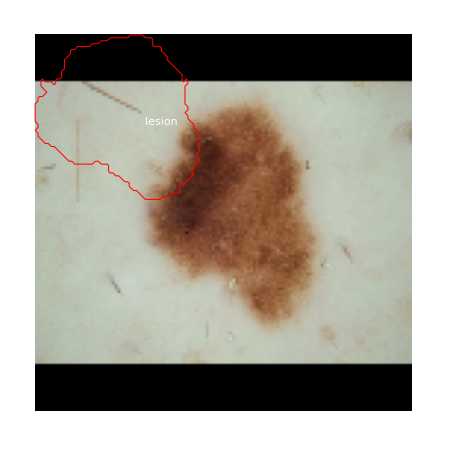

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  214.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   97.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4080, 4)          min:   -0.71267  max:    1.46071  float32


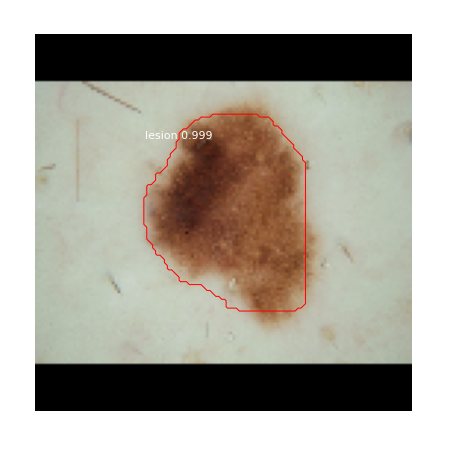

In [29]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8), show_bbox=False, show_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False, show_mask=False)

# 5. Pre-trained model

Zum Vergleich mit unserem trainiertem Modell schauen wir uns jetzt noch die Performance eines 50 Epochen trainierten Modells an.

Aufgabe:

* Fügen Sie den Pfad zur vortrainierten Modelldatei ein

In [26]:
print(PRETRAINED_MODEL_DIR)
!ls -l /models

/models
total 751360
-rw-r--r-- 1 517 999 255967840 Aug 24  2019 mask_rcnn_bone_age_0100.h5
-rw-r--r-- 1 517 999 257557808 Aug 13  2019 mask_rcnn_coco.h5
-rw-r--r-- 1 517 999 255860320 Aug 26  2019 mask_rcnn_isic_0050.h5


In [28]:
class InferenceConfig(ISIC2018Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "___PFAD_EINTRAGEN___"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /models/mask_rcnn_isic_0050.h5


Aufgabe:

- Testen Sie das vortrainierte Netz mit einem Bild Ihrer Wahl

# 6. Evaluation

Ähnlich wie bei der Object Detection wird hier der IoU-Wert berechnet. Diese Zahl liegt zwischen 0 und 1, wobei 0 auf unseren Datensatz bezogen besagt dass die vorausgesagte Maske komplett außerhalb der Lesion liegt, und 1 besagt dass die Maske die Lesion exakt abbildet.

Precision und Recall sind hier weniger interessant, da nur eine Maske pro Bild generiert wird (und es nur eine Klasse gibt), und Precision und Recall entsprechend nur 0 oder 1 sein können.

Der mAP besagt entsprechend eher bei wie vielen untersuchten Bildern die Maske über dem IoU-Threshold gelegen hat, wo also die Lesion korrekt segmentiert wurde.

Ob eine Segmentierungsmaske nun für die oben beschriebenen Maße als korrekt angesehen wird hängt von der Wahl des IoU ab, im Folgenden wird mit einem IoU von 0.75 gearbeitet, d.h. sobald drei Viertel der gefundenen Segmentierungsmaske über der Lesion liegt, wird sie als korrekt angesehen.

Standardmäßig werden 20 Bilder evaluiert und nur diejenigen ausgegeben, bei denen der IoU unterhalb des Threshold liegt, wo also die Lesion nicht korrekt identifiziert wurde.

Aufgabe:

- Testen Sie mit verschiedenen IoU-Thresholds und `print-condition`-Werten

In [31]:
IOU_THRESHOLD = 0.75
NUM_IMAGES = 20

# change this if you want to print only certain images
def print_condition(AP, precisions, recalls, overlaps):
    # Print images below IoU threshold
    return overlaps[0] < IOU_THRESHOLD
    # Uncomment to print all
    #return True
    # Uncomment to print none
    #return False

# Compute VOC-Style mAP @ IoU=0.75
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, NUM_IMAGES, replace=False)
APs = []
IoUs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_ids, gt_bbox, gt_masks =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_ids, gt_masks,
                         r["rois"], r["class_ids"], r["scores"], r['masks'],
                        iou_threshold=IOU_THRESHOLD)
    APs.append(AP)
    IoUs.append(overlaps[0][0])
    
    if print_condition(AP, precisions, recalls, overlaps):
        print("Original:")
        visualize.display_instances(image, gt_bbox, gt_masks, gt_class_ids, 
                                dataset_train.class_names, figsize=(8, 8), show_bbox=False, show_mask=False)
        print("Prediction:")
        print("IoU: ", overlaps[0][0])
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False, show_mask=False)
        plt.show()
    
print("mAP: ", np.mean(APs))
print("mean IoU:", np.mean(IoUs))

ValueError: shapes (2,16384) and (3136,1) not aligned: 16384 (dim 1) != 3136 (dim 0)